# Tutorial
This document is a tutorial of how to use data loader provided by UCTB to deal with data sets, data analysis and a briefly introduction of model building through our data loader.

## Build your own datasets
If you want to apply uctb dataloaders to your dataset, make your dataset compatible with the template as follows:
```python
# Let's say ''my_dataset'' is your dataset.
my_dataset = {
    "TimeRange": ['YYYY-MM-DD', 'YYYY-MM-DD'],
    "TimeFitness": 60, # Minutes
    
    "Node": {
        "TrafficNode": np.array, # With shape [time, num-of-node]
        "StationInfo": list # elements in it should be [id, build-time, lat, lng, name]
        "POI": []   # optional(use '[]' if value is none)
    },

    "Grid": {
        "TrafficGrid": [],  # optional(use '[]' if value is none) np.array, with shape [time, num_rows, num_cols]
        "GridLatLng": [],   # optional(use '[]' if value is none) list, it stores the geographic information of each grid which contains num_rows + 1 horizontal lines' y coordinates and num_columns + 1 vertical lines' x coordinates.
        "POI": []# optional
    },

    "ExternalFeature": {
         "Weather": [time, weather-feature-dim]     # optional(use '[]' if value is none)
    }
}
```
Although it's diffcult to form an integrated function to include all situation you may meet during the transforming process, there are some procedures you might obey to simplify the data preprocessing.
- Data preprocessing
    1. Zero values
    2. Missing values(NA)
    3. Unknown values
    4. Abnormal values
    5. duplicates
    6. Statistics(station number and time slots)
- Dictionary building
    - Basic information(time range and time fitness)
    - Traffic node building
        - Spatio-temporal raster data building 
            1. Allocate memory
            2. Iterate raw data table and fill the matrix
        - Station information
    - Traffic grid builidng
    - External feature

Now, we assume that you have already finished variable preparation. UCTB provide API to assist you with dataset building.

In [ ]:
from dateutil.parser import parse
import pickle
from datetime import timedelta
import os

def build_uctb_dataset(traffic_node, time_fitness, node_station_info, time_range, dataset_name, city,
    traffic_monthly_interaction=None, external_feature_weather=None, node_poi=None, 
    traffic_grid=None, grid_lat_lng=None, gird_poi=None, print_dataset=False, output_dir=None):
    """
    build and return the uctb dataset in dic format
    necessary:
        time_fitness
        time_range
        Node
            traffic_node
            node_satation_info          
        
    optional: 
        Node
            traffic_monthly_interaction
            poi
        Grid
            traffic_grid
            gird_lat_lng
            poi
        ExternalFeature
            Weather
    """
    dataset = {'TimeRange':time_range, 'TimeFitness':time_fitness, 'Node':{'TrafficNode':traffic_node, 'StationInfo':node_station_info},
                    'Grid':{}, 'ExternalFeature':{}, 'LenTimeSlots':traffic_node.shape[0]}

    # make sure no data missing in traffic node
    beg_dt = parse(dataset['TimeRange'][0])
    assert beg_dt+(dataset['Node']['TrafficNode'].shape[0])*get_timedelta(dataset) == parse(dataset['TimeRange'][1])

    dataset['Node']['TrafficMonthlyInteraction'] = traffic_monthly_interaction
    dataset['Grid']['TrafficGrid'] = traffic_grid
    dataset['Grid']['GridLatLng'] = grid_lat_lng
    dataset['ExternalFeature']['Weather'] = [] if external_feature_weather is None else external_feature_weather
    
    if node_poi is not None:
        dataset['Node']['POI'] = node_poi
        
    if gird_poi is not None:
        dataset['Grid']['POI'] = gird_poi
    
    if print_dataset:
        print_dic_info(dataset, 'dataset')

    if output_dir is None:
        pkl_file_name = '{}_{}.pkl'.format(dataset_name, city)
    else:
        pkl_file_name = os.path.join(output_dir, '{}_{}.pkl'.format(dataset_name, city))

    with open(pkl_file_name, 'wb') as f:
        pickle.dump(dataset, f)

build_uctb_dataset(traffic_node=traffic_node, traffic_grid=traffic_grid, time_fitness=time_fitness, node_station_info=node_station_info)


## Load datasets from Urban_dataset
To help better accuse dataset, UCTB provides data loader APIs **UCTB.dataset.data_loader**, which can be used to preprocess data, including data division, normalization, and extract temporal and spatial knowledge.

In the following tutorial, we will illustrate how to use UCTB.dataset.data_loader APIs to inspect the pedestrian dataset.

In [1]:
from UCTB.dataset.data_loader import NodeTrafficLoader

Using TensorFlow backend.


We use all (data_range='all') of pedestrian data in Melbourne as an example. Firstly, let’s initialize a NodeTrafficLoader object:

In [2]:
data_loader = NodeTrafficLoader(city=None,
                 data_range='all',
                 train_data_length='all',
                 test_ratio=0.1,
                 closeness_len=6,
                 period_len=7,
                 trend_len=4,
                 target_length=1,
                 normalize=True,
                 data_dir=None,
                 MergeIndex=1,
                 MergeWay="sum",dataset='../Public_Datasets/Pedestrian/60_minutes/Pedestrian_Melbourne.pkl')

### NodeTrafficLoader 
NodeTrafficLoader is the base class for dataset extracting and processing. Input arguments appeared in constructor above will be explained in following parts.

#### Data structure building 

- data range selection

*'data_range = all'* means that we choose the whole data as our traffic_data to train, test, and predict.

- data spliting(train set and test set spliting)

*'train_data_length' = 'all'* means that we exploit all of the traffic_data. *'train_test_ratio = 0.1'* means we divide the dataset into training and test sets. And the training set to the test set is nine to one.

- normalization

*'normalization=True'* means that we normalized the dataset through min-max-normalization method. When we input False, we simply do not employ any preprocessing tricks on the dataset.

- data merging

*'MergeIndex = 1, MergeSum = "sum"'* means that granularity of raw dataset will not be changed. If we try MergeIndex > 1, we can obtain combination of MergeIndex time slots of data in a way of 'sum' or 'average'. 

- multiple time series building(temporal features building)

*'closeness_len=6,
                 period_len=7,
                 trend_len=4,
                 target_length=1'* means that we create 3 time series, using former consecutive closeness_len time slots of data as a unit, former every other daily_slots time slots of data as a unit(consisting of period_len piece of data), former every other daily_slots\*7 time slots of data as a unit(consisting of trend_len piece of data) respectively.


In [3]:
print(data_loader.train_closeness.shape)
print(data_loader.train_period.shape)
print(data_loader.train_trend.shape)
print(data_loader.train_data.shape)

(100584, 70, 6, 1)
(100584, 70, 7, 1)
(100584, 70, 4, 1)
(101256, 70)


You may probably note that the length of train_closeness is 672 less than that of train_data. It's because we choose the shortest data length among the three series(train_trend) for alignment.
![visualization of temporal knowledge](../images/data_reassemble.png)

Above is the visualization of a new *time series*'s construction.In this situation, feature_stride = 3(means sampling interval), feature_step = 3(means how many times we sample).Other time series are just the same situation.

Through the process in the figure shown above, we can calculate the length of train_trend is $101256-24*7*4-1=100584$, which is the minimum among three time series.

#### Operations
- Denormalization/Normalization
- visualization
- Feature stitching
- Spatial knowledge exploration
- Access to raw data


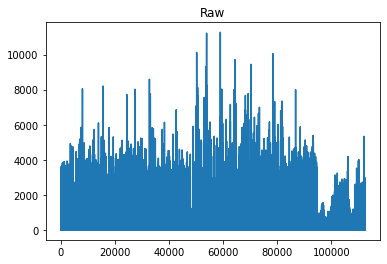

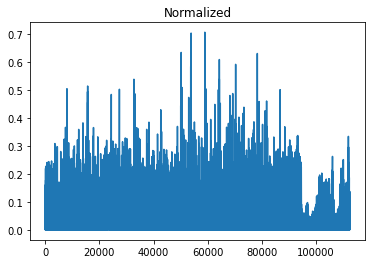

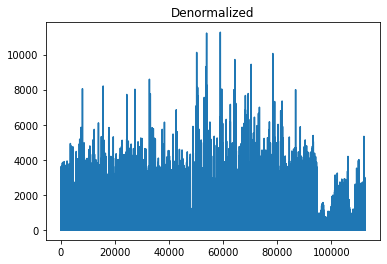

In [4]:


import matplotlib.pyplot as plt
from UCTB.preprocess.preprocessor import Normalizer

# without normalization

target_node = 5
plt.plot(data_loader.traffic_data[:,5])
plt.title('Raw')
plt.show()

# normalization

normalizer=Normalizer(data_loader.traffic_data)
X_normalized = normalizer.min_max_normal(data_loader.traffic_data)

# denormalization

X_denormalized = normalizer.min_max_denormal(X_normalized)

plt.plot(X_normalized[:,5])
plt.title('Normalized')
plt.show()
plt.plot(X_denormalized[:,5])
plt.title('Denormalized')
plt.show()

In [ ]:
# Nodes' location visualizations
data_loader.st_map()

Visualization result is as follows:

<img src="../images/Pedestrain_Melbourne.png" style="zoom: 33%; height: 800px; width: 800px;"/>

In [ ]:
# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
real_denormed=data_loader.normalizer.min_max_denormal(data_loader.test_y)
sns.heatmap(real_denormed[:,:,0], cmap='Reds', vmin = -1000, vmax = 4000)
plt.ylabel("Time Slot")
plt.xlabel("Sensor Node")
plt.title("Visualization")
plt.show()

In [7]:
# Feature stitching
X = data_loader.make_concat()
print('before concatenate')
print('closeness')
print(data_loader.train_closeness.shape)
print('period')
print(data_loader.train_period.shape)
print('trend')
print(data_loader.train_trend.shape)
print('After concatenate')
print(X.shape)

before concatenate
closeness
(100584, 70, 6, 1)
period
(100584, 70, 7, 1)
trend
(100584, 70, 4, 1)
After concatenate
(100584, 70, 17, 1)


In [8]:
# access to raw data
print(data_loader.traffic_data[0,0])

52.0


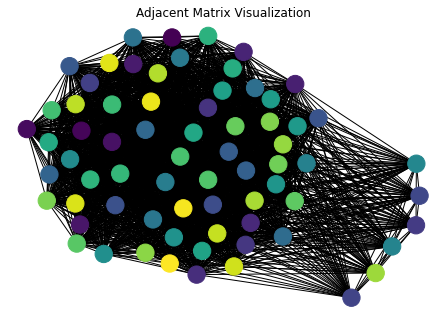

In [9]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from UCTB.preprocess.GraphGenerator import GraphGenerator

# Some parameters
threshold_distance = 500
threshold_correlation = 0
def get_matrix_triad(coo_matrix , data=False):
	# check type
	if not sp.isspmatrix_coo(coo_matrix):
		coo_matrix = sp.coo_matrix(coo_matrix)
	temp = np.vstack((coo_matrix.row , coo_matrix.col , coo_matrix.data)).transpose()
	return temp.tolist()

graphBuilder = GraphGenerator (data_loader,threshold_correlation = threshold_correlation)


Matrix=graphBuilder.AM[0]
edags = get_matrix_triad(Matrix)
G = nx.Graph()
H = nx.path_graph(Matrix.shape[0]) 
G.add_nodes_from(H)
G.add_weighted_edges_from(edags,weight='weight')
colors = np.arange(Matrix.shape[0])
nx.draw(G,pos=nx.spring_layout(G),node_color=colors)
plt.title('Adjacent Matrix Visualization')
plt.show()



You can find more graph building method and results in this [doc](https://uctb.github.io/UCTB/UCTB.preprocess.html#uctb-preprocess-graphgenerator-module)

## Model building
Our data loader can apply to different kinds of demand in model building. 
### Utilize simple models to predict
We can simply use XGBoost to construct our predicting model.

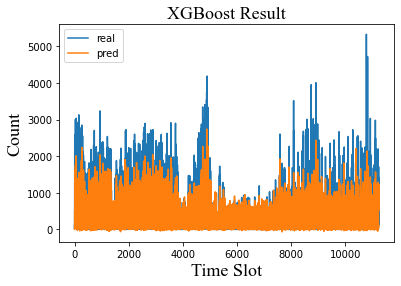

Test RMSE 468.06454


In [10]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from UCTB.evaluation import metric
from UCTB.preprocess import Normalizer
# select prediction target
target_node = 5

# some parameters setting
max_depth = 3
objective = 'reg:squarederror'
param = {
            'max_depth': max_depth,
            'objective': objective,
        }
n_estimators = 200
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 18,
}
normalizer=Normalizer(data_loader.traffic_data)

# forming data fed to XGBoost model from data_loader 
train_closeness = data_loader.train_closeness[:, target_node, :, 0]
train_y = data_loader.train_y[:, target_node, 0]

test_closeness = data_loader.test_closeness[:, target_node, :, 0]
test_y = data_loader.test_y[:, target_node, 0]

train_X = train_closeness
test_X = test_closeness

# model building and training
train_matrix = xgb.DMatrix(train_X, label=train_y)
model = xgb.train(param, train_matrix, n_estimators)

# prediction
test_matrix = xgb.DMatrix(test_X)
predictions=model.predict(test_matrix)

# plot
plt.xlabel("Time Slot",font)         
plt.ylabel("Count",font) 
plt.title("XGBoost Result",font)
plt.plot(normalizer.min_max_denormal(test_y),label='real')
plt.plot(normalizer.min_max_denormal(predictions),label='pred')
plt.legend()
plt.show()
print('Test RMSE', metric.rmse(normalizer.min_max_denormal(predictions), normalizer.min_max_denormal(test_y), threshold=0))


### Utilize UCTB to predict
Although XGBoost can work really well in many situation, it only mine patterns from time series themselves. Different to XGBoost, many of models in UCTB can combine spatial knowledge and temporal knowledge, which means larger possiblity of finding more accurate pattern of data. Besides, the models in this framework fit very well with our data loader, which reduces complexity of operations.

If you want to learn more about how to use UCTB to build models and make predictions, you can visit this [website](https://uctb.github.io/UCTB/md_file/introduction.html) where more detailed description and instruction will be found.